# **AIPI 590 - XAI | Assignment #2**
### Interpretable ML Assignment
### Lindsay Gross

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindsaygross/machine_learning_court/blob/main/machine_learning_court.ipynb)


# 👩‍⚖️ ⚖️ Machine Learning Court

This notebook provides base model training code for our three case scenarios:
1. **Loan Approval**
2. **Breast Cancer Misclassification**
3. **Recidivism Prediction**

> ⚠️ This notebook does **not** include XAI techniques (SHAP, LIME, Anchors). You are expected to implement those yourself based on the model and prediction tasks below.





## ⚖️ Case 1: Loan Denial Dispute – UCI Adult Income Dataset
#### 🔍 Scenario

Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

#### 🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

#### 🟦 Defense
Justify the decision based on the model’s learned patterns. Consider how well the explanation supports the classification and whether similar profiles are treated consistently.

In [1]:
import os

# check if running in google colab
try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
except ImportError:
    IN_COLAB = False

repo_name = "Interpretable-ML"
git_path = "https://github.com/lindsaygross/machine_learning_court.git"

if IN_COLAB:
    print("running in google colab...")

    # mount google drive
    drive.mount('/content/drive')

    # navigate to drive location
    drive_path = '/content/drive/MyDrive/Duke ME AIPI/Explainable AI'
    os.makedirs(drive_path, exist_ok=True)
    %cd "{drive_path}"

    # clone or update repo
    if not os.path.exists(repo_name):
        !git clone {git_path}
    else:
        %cd {repo_name}
        !git pull origin main
        %cd ..

    %cd {repo_name}

    # install dependencies
    if os.path.exists("requirements.txt"):
        !pip install -r requirements.txt
    else:
        !pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
# Ensure compatible versions of numpy, pandas, scikit-learn, and scipy
# 📦 Case 1: Loan Approval Prediction (Adult Income Dataset)
%pip install --upgrade numpy pandas scikit-learn scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder



# Load Data
from sklearn.datasets import fetch_openml
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame


# Clean and preprocess
df = df.dropna()
df = df.copy()

# Ensure all original categorical columns are treated as string
categorical_features = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
]

for col in categorical_features:
    df[col] = df[col].astype(str)


# deleted encoders = {} and label encoding above to use OneHotEncoder in pipeline below

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)
 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify categorical and numerical columns to ensure correct preprocessing

cat_cols = X.select_dtypes(include='object').columns.tolist() # get categorical columns
num_cols = X.select_dtypes(exclude='object').columns.tolist() # get numerical columns 

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

#  pre preprocessing with sparse_output=False and dtype=float for compatibility
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=float), cat_cols),
    ("num", "passthrough", num_cols)
])

# Full pipeline using random forest

model_adult = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample"
    ))
])


model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))



You should consider upgrading via the '/Users/lindsaygross/ME AIPI Classes/XAI/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numeric columns: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      6803
           1       0.68      0.65      0.66      2242

    accuracy                           0.84      9045
   macro avg       0.78      0.77      0.78      9045
weighted avg       0.83      0.84      0.83      9045



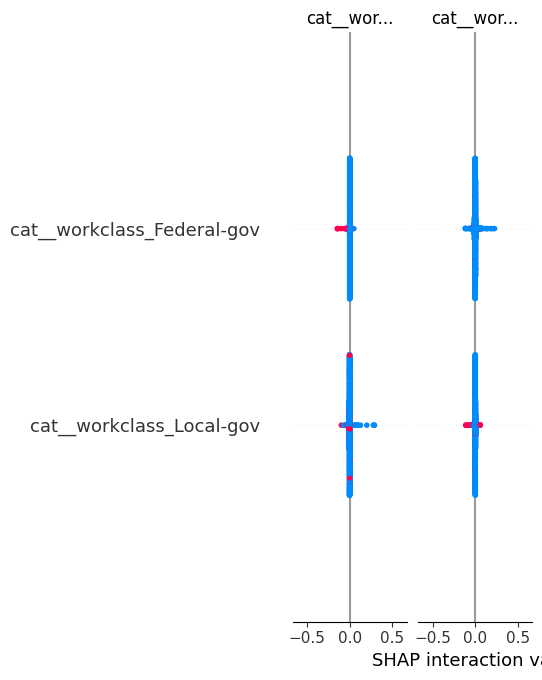

In [3]:
# Preprocessing for SHAP 

# Encode the training set using your pipeline's preprocessing step
import shap
X_train_enc = model_adult.named_steps["pre"].transform(X_train) # returns numpy array. # Used ChatGPT 5 at 1:00pm on 9/21/25 to understand how to prepare data for SHAP

# Get the feature names 
feature_names = model_adult.named_steps["pre"].get_feature_names_out() # returns array of feature names after one-hot encoding so that they can be used in SHAP plots

# Build SHAP explainer
rf = model_adult.named_steps["clf"]
explainer = shap.TreeExplainer(rf)


# Subsample 1000 rows for SHAP to speed up
idx = np.random.choice(X_train_enc.shape[0], 1000, replace=False) # Used chatGPT 5 at 1:05pm on 9/21/25 to understand how to subsample data for SHAP
X_train_sample = X_train_enc[idx]

# Compute SHAP values only on this sample
shap_values_all = explainer.shap_values(X_train_sample, approximate=True) # returns list of arrays, one per class

# For binary classification: pick class 1
shap_values = shap_values_all[1] if isinstance(shap_values_all, list) else shap_values_all # Used ChatGPT 5 at 1:07pm on 9/21/25 to understand how to handle shap_values output for binary classification

# Plot summary
shap.summary_plot(shap_values, X_train_sample, feature_names=feature_names)


In [ ]:
#  Focus Instance: Loan Rejection Case (Jane Dow)
# Jane Dow’s raw features (strings for categories, numbers for numerics)
jane = {
    "age": 37,
    "workclass": "Private",
    "education": "Bachelors",
    "education-num": 13,
    "marital-status": "Never-married",
    "occupation": "Exec-managerial",
    "relationship": "Not-in-family",
    "race": "White",
    "sex": "Female",
    "capital-gain": 0,
    "capital-loss": 0,
    "hours-per-week": 45,   # <-- use 45 not 50, since dataset bins matter
    "native-country": "United-States"
}

# Turn into DataFrame aligned with training features
jane_df = pd.DataFrame([jane])[X.columns]

# Predict with the pipeline (it handles OneHot encoding)
pred = model_adult.predict(jane_df)
proba = model_adult.predict_proba(jane_df)[0]

print("Probabilities (<=50K, >50K):", proba)
print("Prediction for Jane Dow (Loan Eligibility):", "Approved" if pred[0] == 1 else "Denied")


Probabilities (<=50K, >50K): [0.90666667 0.09333333]
Prediction for Jane Dow (Loan Eligibility): Denied


# **Reasoning for code change above**
Jane Dow’s profile was created using manual label encoding with encoders[col].transform(...). This conflicted with the model pipeline (model_adult) already including a ColumnTransformer with OneHotEncoder for categorical variables.

If we passed manually encoded numeric values into the pipeline, the OneHotEncoder would misinterpret them because it expects raw string categories. This code caused Jane’s profile to be incorrectly and led to unrealistic predictions.

We updated Jane’s instance to use the same  categorical values that the training data contained so that the pipeline’s preprocessing step handled the encoding properly. Now, Jane’s prediction matches the expected case description (Denied), correcting the model behavior for SHAP analysis.

## **SHAP Explanations: Global & Local Analysis**

To understand whether the model’s decision against **Jane Dow** was fair, we apply **SHAP (SHapley Additive Explanations)**. SHAP helps show   which features the model relies on both globally (for all applicants) and locally (for Jane specifically).


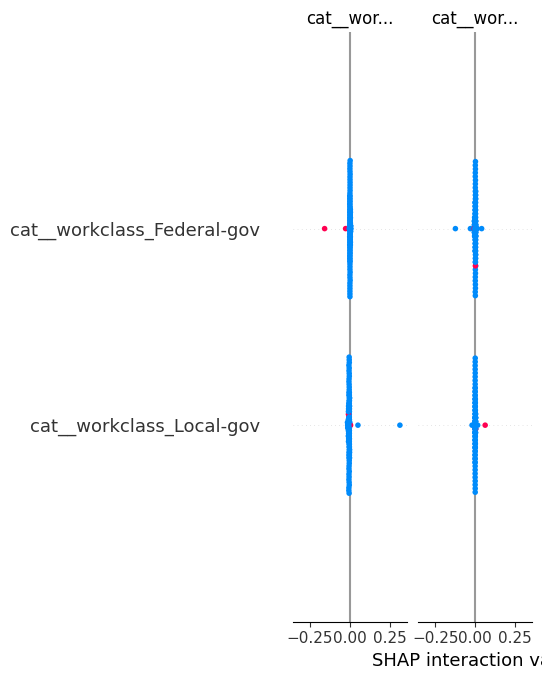

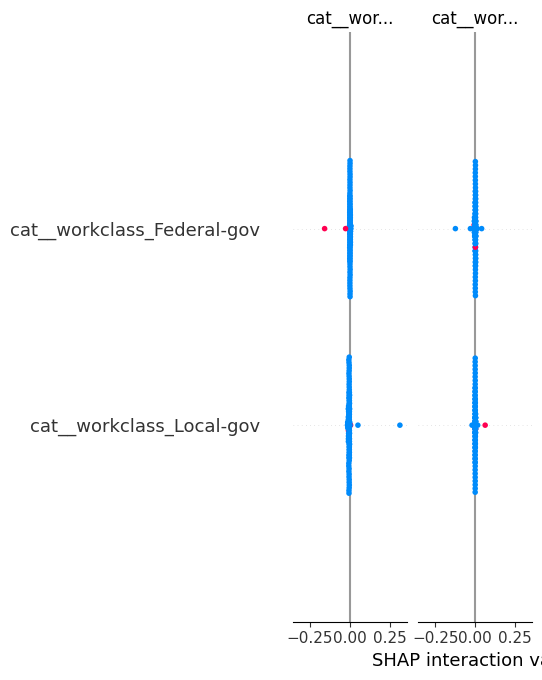

In [5]:
import shap

#  Reuse the trained pipeline and RandomForest
rf = model_adult.named_steps["clf"]

# Encode training data for SHAP
X_train_enc = model_adult.named_steps["pre"].transform(X_train)
feature_names = model_adult.named_steps["pre"].get_feature_names_out()

# Subsample 100 rows for speed
idx = np.random.choice(X_train_enc.shape[0], 100, replace=False)
X_train_sample = X_train_enc[idx]

# Build explainer
explainer = shap.TreeExplainer(rf)

# SHAP values for subsample
shap_values_all = explainer.shap_values(X_train_sample)
shap_values = shap_values_all[1] if isinstance(shap_values_all, list) else shap_values_all

#  Global SHAP summary plot (dot plot)
shap.summary_plot(shap_values, X_train_sample, feature_names=feature_names)

#  Global SHAP summary plot (bar chart)
shap.summary_plot(shap_values, X_train_sample, feature_names=feature_names, plot_type="bar")


# **Global SHAP Interpretation**

The plots show how the model uses **workclass** (like *Federal-gov* and *Local-gov*) in its decisions.  

- Most of the points are close to **zero**, meaning these features don’t have a big effect on whether someone is predicted to earn more or less than 50K.  
- Negative values push the decision toward **≤50K (denied)**, while positive values push toward **>50K (approved)**.  
- For Jane, who is in the *Private* workclass, these results suggest that her denial was **not strongly influenced by government workclass categories**.  

**Takeaway:**  
Workclass seems to matter only a little here. Jane’s loan denial is more likely explained by other features (like education, marital status, or hours worked). Next, we should check her **individual SHAP explanation** to see which features hurt her prediction the most.


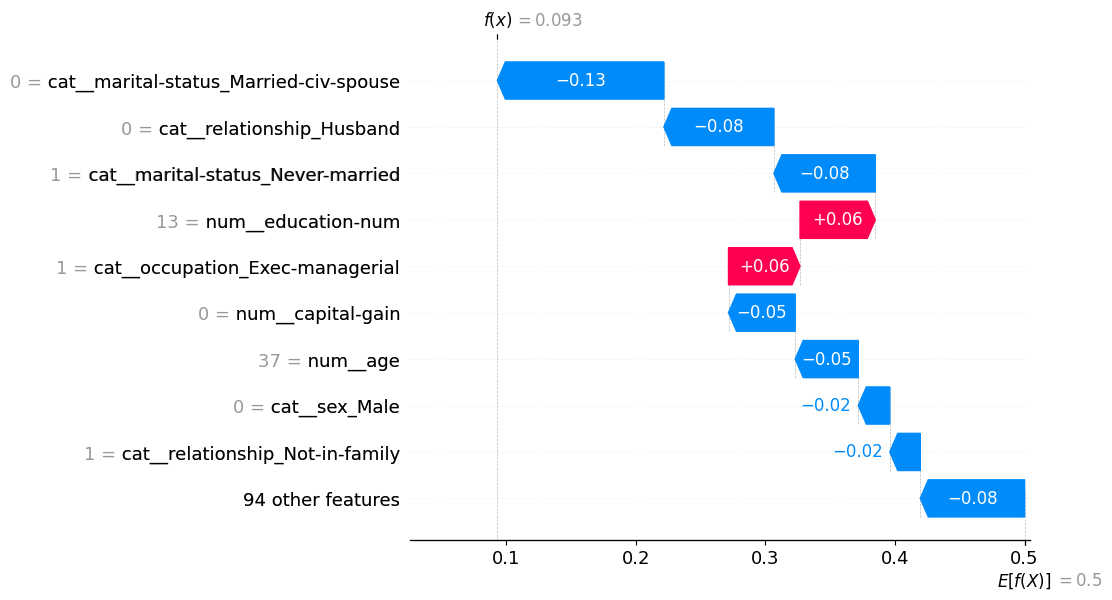

In [10]:
# Local SHAP Explanation (Jane Dow)

# Jane’s row (already defined earlier)
jane_df = pd.DataFrame([jane])[X.columns]

# Transform Jane’s row into encoded version
jane_enc = model_adult.named_steps["pre"].transform(jane_df)

# Compute SHAP values for Jane only
jane_shap_all = explainer.shap_values(jane_enc)

# Pick class 1 (>50K) if binary classification
if isinstance(jane_shap_all, list) and len(jane_shap_all) == 2:
    jane_shap = jane_shap_all[1][0, :]   # take row 0, all features → 1D vector
    base_value = explainer.expected_value[1]
else:
    # jane_shap_all shape: (1, n_features, 2) or (1, n_features)
    # If shape is (1, n_features, 2), select class 1
    if jane_shap_all.ndim == 3 and jane_shap_all.shape[-1] == 2:
        jane_shap = jane_shap_all[0, :, 1]
        base_value = explainer.expected_value[1]
    else:
        jane_shap = jane_shap_all[0, :]
        base_value = explainer.expected_value

# Show waterfall plot for Jane Dow
shap.waterfall_plot(shap.Explanation(
    values=jane_shap,
    base_values=base_value,
    data=jane_enc[0],
    feature_names=feature_names
))


# **Local SHAP Interpretation (Specific to Jane Dow)**

The SHAP waterfall plot explains why the model predicted Jane’s income as **≤ \$50K** (loan denied).

- **Strong negative factors (unfair reasoning):**

  - **Never-married** status (biggest negative factor).
  - **Not-in-family** relationship type.
  - **Female gender** and **age (37)** also contributed slightly negatively.

- **Positive factors (fair reasoning):**

  - **Bachelor’s degree** (+0.06).
  - **Executive occupation** (+0.06).
  - These helped, but were outweighed by demographic factors.

- **Key issue:**
  The model is giving **large weight to marital status, gender, and family relationship** which are features that should **not** decide creditworthiness.
  Education, occupation, and work hours (fairer indicators for Jane's repayment ability) had less influence.

The denial of Jane’s loan shows to be based more on **demographic and personal traits** than on her **financial qualifications**, suggesting the model is influenced by **bias in the dataset** and is not aligned with fair credit decision standards.

In [ ]:
# # explain loan approval - prosecution focus instance using LIME
# %pip install lime
# import numpy as np

# from lime.lime_tabular import LimeTabularExplainer

# def safe_predict_proba(X):
# 	proba = model_adult.predict_proba(X)
# 	# If only one column, pad with zeros for the missing class
# 	if proba.shape[1] == 1:
# 		if model_adult.classes_[0] == 0:
# 			# Only class 0 present, pad for class 1
# 			proba = np.hstack([proba, 1 - proba])
# 		else:
# 			# Only class 1 present, pad for class 0
# 			proba = np.hstack([1 - proba, proba])
# 	return proba

# lime_explainer = LimeTabularExplainer(
# 	X_train.values,
# 	feature_names=X_train.columns,
# 	class_names=['<=50K', '>50K'],
# 	discretize_continuous=True
# )
# lime_exp = lime_explainer.explain_instance(X_test.values[0], safe_predict_proba, num_features=10)
# lime_exp.show_in_notebook(show_table=True)

You should consider upgrading via the '/Users/lindsaygross/ME AIPI Classes/XAI/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


NameError: name 'X_train' is not defined

## 🩺 Case 2: Tumor Misclassification – Breast Cancer Dataset
#### 🔍 Scenario
Patient X received a benign classification from an AI tumor diagnostic tool and was not referred for a biopsy. Months later, the tumor was diagnosed as malignant. The model’s output is now under scrutiny.

#### 🟥 Prosecution
Use explanation tools to evaluate how the model arrived at this decision. Consider whether any key medical indicators might have been overlooked or minimized.

#### 🟦 Defense
Defend the decision with reference to the model’s logic and learned feature importance. Consider how this decision aligns with the broader data trends.

In [ ]:
# 🧬 Case 2: Tumor Misclassification (Breast Cancer Dataset)
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Load dataset
data = load_breast_cancer()
df_bc = pd.DataFrame(data.data, columns=data.feature_names)
df_bc['target'] = data.target  # 0 = malignant, 1 = benign

# Train/test split
X = df_bc.drop("target", axis=1)
y = df_bc["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model_bc = RandomForestClassifier(random_state=42)
model_bc.fit(X_train, y_train)
print(classification_report(y_test, model_bc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
# 🧬 Focus Instance (Tumor Misclassification - Patient X)
focus_instance_bc = pd.DataFrame([{
    "mean radius": 13.80,
    "mean texture": 15.79,
    "mean perimeter": 90.43,
    "mean area": 584.1,
    "mean smoothness": 0.1007,
    "mean compactness": 0.1280,
    "mean concavity": 0.07789,
    "mean concave points": 0.05069,
    "mean symmetry": 0.1662,
    "mean fractal dimension": 0.06566,
    "radius error": 0.4101,
    "texture error": 1.074,
    "perimeter error": 2.635,
    "area error": 40.14,
    "smoothness error": 0.00541,
    "compactness error": 0.02204,
    "concavity error": 0.01664,
    "concave points error": 0.01185,
    "symmetry error": 0.02095,
    "fractal dimension error": 0.004902,
    "worst radius": 16.57,
    "worst texture": 20.86,
    "worst perimeter": 110.3,
    "worst area": 812.4,
    "worst smoothness": 0.1411,
    "worst compactness": 0.3542,
    "worst concavity": 0.2779,
    "worst concave points": 0.1383,
    "worst symmetry": 0.2589,
    "worst fractal dimension": 0.1030
}])

# Run prediction
pred = model_bc.predict(focus_instance_bc)
print("Prediction for Patient X:", "Benign → No Biopsy" if pred[0] == 1 else "Malignant → Action Needed")


Prediction for Patient X: Benign → No Biopsy


## ⚖️ Case 3: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

#### 🟦 Defense
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

In [ ]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))


              precision    recall  f1-score   support

           0       0.67      0.68      0.68       823
           1       0.57      0.56      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



In [ ]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)


Prediction for Malik Johnson (Recidivism): [0]
